In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import os
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# path = '/kaggle/working/data'
# if not os.path.exists(path):
#     os.mkdir(path)

# transforms = transforms.Compose([transforms.ToTensor()])
# trainset = datasets.CIFAR10(root=path, train=True, download=True, transform=transforms)
# testset = datasets.CIFAR10(root=path, train=False, download=True, transform=transforms)


# trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=False, num_workers=2)
# # 이미지 평균 및 표준편차 계산
# mean = torch.zeros(3)
# std = torch.zeros(3)
# nb_samples = 0.0
# for images, _ in trainloader:
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1)
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
#     nb_samples += batch_samples
    
# mean /= nb_samples
# std /= nb_samples

# mean = mean.numpy().tolist()
# std = std.numpy().tolist()

# print(mean)
# print(std)

In [4]:
path = '/kaggle/working/data'
if not os.path.exists(path):
    os.mkdir(path)

# 데이터셋 전처리
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 수평으로 뒤집기
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # 색상 변형
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])


# CIFAR-10
trainset = datasets.CIFAR10(root=path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root=path, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 49159719.79it/s]


Extracting /kaggle/working/data/cifar-10-python.tar.gz to /kaggle/working/data
Files already downloaded and verified


In [5]:
class bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(bottleneck, self).__init__()
        self.k = growth_rate
        self.res = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, 4*self.k, kernel_size=1, bias=False),
            nn.BatchNorm2d(4*self.k),
            nn.ReLU(),
            nn.Conv2d(4*self.k, self.k, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([self.res(x), x], dim=1)

In [15]:
class transition(nn.Module):
    def __init__(self, in_channels):
        super(transition, self).__init__()
        self.trans = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, int(in_channels/2), kernel_size=1, bias=False),
            nn.AvgPool2d(2)
        )
    def forward(self, x):
        return self.trans(x)

In [39]:
class DenseNet(nn.Module):
    def __init__(self, block_list, growth_rate, num_classes = 1000):
        super().__init__()

        assert len(block_list) == 4

        self.k = growth_rate

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 2 * self.k, 7, stride = 2, padding = 3, bias = False),
            nn.BatchNorm2d(2 * self.k),
            nn.ReLU(),
        )
        self.maxpool = nn.MaxPool2d(3, stride = 2, padding = 1)

        self.dense_channels = 2 * self.k
        dense_blocks = []
        dense_blocks.append(self.make_dense_block(block_list[0]))
        dense_blocks.append(self.make_dense_block(block_list[1]))
        dense_blocks.append(self.make_dense_block(block_list[2]))
        dense_blocks.append(self.make_dense_block(block_list[3], last_stage = True))
        self.dense_blocks = nn.Sequential(*dense_blocks)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.dense_channels, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.dense_blocks(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
    def make_dense_block(self, num_blocks, last_stage = False):
        layers = []
        for _ in range(num_blocks):
            layer = bottleneck(self.dense_channels, self.k)
            layers.append(layer)
            self.dense_channels += self.k

        if last_stage:
            layers.append(nn.BatchNorm2d(self.dense_channels))
            layers.append(nn.ReLU())
        else:
            layers.append(transition(self.dense_channels))
            assert self.dense_channels % 2 == 0
            self.dense_channels //= 2
            
        return nn.Sequential(*layers)

In [40]:
def DenseNet121():
    return DenseNet(block_list=[6, 12, 24, 16], growth_rate=32)

def DenseNet169():
    return DenseNet(block_list=[6, 12, 32, 32], growth_rate=32)

def DenseNet201():
    return DenseNet(block_list=[6, 12, 48, 32], growth_rate=32)

def DenseNet264():
    return DenseNet(block_list=[6, 12, 64, 48], growth_rate=32)

In [41]:
!pip install torchsummary
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121().to(device)


summary(model, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
       bottleneck-11           [-1, 96, 56, 56]               0
      BatchNorm2d-12           [-1, 96, 56, 56]             192
             ReLU-13           [-1, 96, 56, 56]               0
           Conv2d-14          [-1, 128,

In [45]:
# CUDA 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
initial_learning_rate = 0.1

# loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=initial_learning_rate, momentum=0.9, weight_decay=0.0001)

# scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225], gamma=0.1)

In [46]:
# 모델을 CUDA로 이동
model.to(device)

def model_train(model, data_loader, criterion, optimizer, epoch):
    model.train()

    global epoch_step
    running_size, running_loss, correct = 0.0, 0.0, 0.0

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        pbar = tqdm(data_loader)
    else:
        pbar = data_loader

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_size += images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar.set_description('[Training] loss: ' +
                                f'{running_loss / running_size:.4f}, accuracy: ' +
                                f'{correct / running_size:.4f}')
        del images, labels, outputs, loss
        torch.cuda.empty_cache()
        
    avg_accuracy = correct / running_size
    avg_loss = running_loss / running_size

    return avg_loss, avg_accuracy

def model_eval(model, data_loader, criterion, epoch):
    model.eval()
    with torch.no_grad():
        running_loss, correct = 0.0, 0.0

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar = tqdm(data_loader)
        else:
            pbar = data_loader

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = outputs.argmax(dim=1)

            correct += torch.sum(pred == labels).item()
            running_loss += criterion(outputs, labels).item() * images.size(0)

        accuracy = correct / len(data_loader.dataset)
        loss = running_loss / len(data_loader.dataset)
        return loss, accuracy

In [49]:
# 모델 학습 및 평가 코드
loss, accuracy = [], []
num_epochs = 300
epoch_step = 10

for epoch in range(num_epochs):
    train_loss, train_accuracy = model_train(model, trainloader, criterion, optimizer, epoch)
    test_loss, test_accuracy = model_eval(model, testloader, criterion, epoch)

    loss.append([train_loss, test_loss])
    accuracy.append([train_accuracy, test_accuracy])

    scheduler.step()  # 스케줄러 업데이트

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f"epoch {epoch+1:03d}, Training loss: " + 
              f"{train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

# 모델 상태 저장
model_save_path = '/kaggle/working/data/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

100%|██████████| 157/157 [00:06<00:00, 23.54it/s]

epoch 001, Training loss: 1.5326, Training accuracy: 0.4452
Test loss: 1.4567, Test accuracy: 0.4688



100%|██████████| 157/157 [00:06<00:00, 23.37it/s]

epoch 010, Training loss: 0.9895, Training accuracy: 0.6540
Test loss: 0.9893, Test accuracy: 0.6517



100%|██████████| 157/157 [00:06<00:00, 23.62it/s]

epoch 020, Training loss: 0.7787, Training accuracy: 0.7293
Test loss: 0.8923, Test accuracy: 0.6978



100%|██████████| 157/157 [00:06<00:00, 23.88it/s]

epoch 030, Training loss: 0.6836, Training accuracy: 0.7625
Test loss: 0.7832, Test accuracy: 0.7325



100%|██████████| 157/157 [00:06<00:00, 23.04it/s]

epoch 040, Training loss: 0.6316, Training accuracy: 0.7814
Test loss: 0.7547, Test accuracy: 0.7484



100%|██████████| 157/157 [00:06<00:00, 22.75it/s]

epoch 050, Training loss: 0.5937, Training accuracy: 0.7941
Test loss: 0.6506, Test accuracy: 0.7757



100%|██████████| 157/157 [00:06<00:00, 23.67it/s]

epoch 060, Training loss: 0.5663, Training accuracy: 0.8056
Test loss: 0.6626, Test accuracy: 0.7680



100%|██████████| 157/157 [00:06<00:00, 22.57it/s]

epoch 070, Training loss: 0.5416, Training accuracy: 0.8139
Test loss: 0.6247, Test accuracy: 0.7939



100%|██████████| 157/157 [00:06<00:00, 23.20it/s]

epoch 080, Training loss: 0.5323, Training accuracy: 0.8162
Test loss: 0.6427, Test accuracy: 0.7844



100%|██████████| 157/157 [00:06<00:00, 24.09it/s]

epoch 090, Training loss: 0.5205, Training accuracy: 0.8222
Test loss: 0.6216, Test accuracy: 0.7908



100%|██████████| 157/157 [00:06<00:00, 23.12it/s]

epoch 100, Training loss: 0.5171, Training accuracy: 0.8205
Test loss: 0.6709, Test accuracy: 0.7758



100%|██████████| 157/157 [00:06<00:00, 23.61it/s]

epoch 110, Training loss: 0.5136, Training accuracy: 0.8249
Test loss: 0.6125, Test accuracy: 0.7933



100%|██████████| 157/157 [00:06<00:00, 22.89it/s]

epoch 120, Training loss: 0.5102, Training accuracy: 0.8243
Test loss: 0.6471, Test accuracy: 0.7860



100%|██████████| 157/157 [00:06<00:00, 23.77it/s]

epoch 130, Training loss: 0.5006, Training accuracy: 0.8256
Test loss: 0.5995, Test accuracy: 0.7964



100%|██████████| 157/157 [00:06<00:00, 23.18it/s]

epoch 140, Training loss: 0.5031, Training accuracy: 0.8254
Test loss: 0.5977, Test accuracy: 0.7939



100%|██████████| 157/157 [00:06<00:00, 22.49it/s]

epoch 150, Training loss: 0.4907, Training accuracy: 0.8312
Test loss: 0.6090, Test accuracy: 0.7921



100%|██████████| 157/157 [00:06<00:00, 23.44it/s]

epoch 160, Training loss: 0.4994, Training accuracy: 0.8279
Test loss: 0.5979, Test accuracy: 0.8006



100%|██████████| 157/157 [00:06<00:00, 22.62it/s]

epoch 170, Training loss: 0.4951, Training accuracy: 0.8303
Test loss: 0.6197, Test accuracy: 0.7927



100%|██████████| 157/157 [00:06<00:00, 23.41it/s]

epoch 180, Training loss: 0.4851, Training accuracy: 0.8338
Test loss: 0.6216, Test accuracy: 0.7923



100%|██████████| 157/157 [00:06<00:00, 22.83it/s]

epoch 190, Training loss: 0.4865, Training accuracy: 0.8297
Test loss: 0.5984, Test accuracy: 0.8001



100%|██████████| 157/157 [00:06<00:00, 22.80it/s]

epoch 200, Training loss: 0.4869, Training accuracy: 0.8305
Test loss: 0.6206, Test accuracy: 0.7922



100%|██████████| 157/157 [00:06<00:00, 23.34it/s]

epoch 210, Training loss: 0.4859, Training accuracy: 0.8328
Test loss: 0.6163, Test accuracy: 0.7845



100%|██████████| 157/157 [00:06<00:00, 23.27it/s]

epoch 220, Training loss: 0.4786, Training accuracy: 0.8343
Test loss: 0.5822, Test accuracy: 0.8031



100%|██████████| 157/157 [00:06<00:00, 22.89it/s]

epoch 230, Training loss: 0.4794, Training accuracy: 0.8344
Test loss: 0.6136, Test accuracy: 0.7973



100%|██████████| 157/157 [00:07<00:00, 22.08it/s]

epoch 240, Training loss: 0.4842, Training accuracy: 0.8329
Test loss: 0.6597, Test accuracy: 0.7773



100%|██████████| 157/157 [00:07<00:00, 21.38it/s]

epoch 250, Training loss: 0.4749, Training accuracy: 0.8357
Test loss: 0.6556, Test accuracy: 0.7878



100%|██████████| 157/157 [00:07<00:00, 22.12it/s]

epoch 260, Training loss: 0.4736, Training accuracy: 0.8372
Test loss: 0.5801, Test accuracy: 0.8075



100%|██████████| 157/157 [00:07<00:00, 21.72it/s]

epoch 270, Training loss: 0.4811, Training accuracy: 0.8335
Test loss: 0.5839, Test accuracy: 0.8006



100%|██████████| 157/157 [00:06<00:00, 22.62it/s]

epoch 280, Training loss: 0.4677, Training accuracy: 0.8391
Test loss: 0.6147, Test accuracy: 0.7985



100%|██████████| 157/157 [00:06<00:00, 22.68it/s]

epoch 290, Training loss: 0.4746, Training accuracy: 0.8360
Test loss: 0.6063, Test accuracy: 0.7927



100%|██████████| 157/157 [00:06<00:00, 22.48it/s]


epoch 300, Training loss: 0.4692, Training accuracy: 0.8378
Test loss: 0.6148, Test accuracy: 0.7959
Model saved to /kaggle/working/data/model.pth


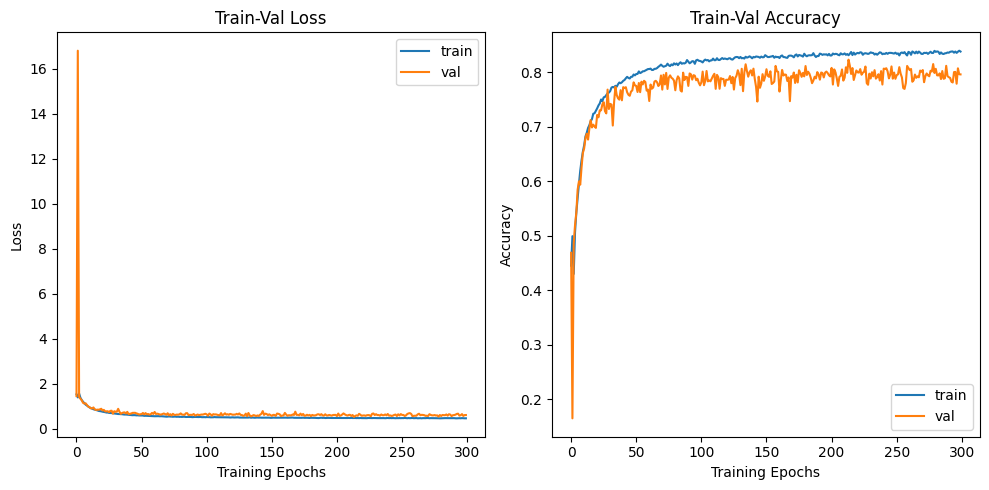

In [50]:
import matplotlib.pyplot as plt

# 손실 그래프
train_losses, val_losses = zip(*loss)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train-Val Loss')

# 정확도 그래프
train_accuracies, val_accuracies = zip(*accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train-Val Accuracy')

plt.tight_layout()
plt.show()